In [ ]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from agent import Agent

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
LEARNING_RATE = 0.0001

gamma = 0.99
max_num_episodes = 1000
hidden_size = 128

print_every = 10

In [3]:
env = gym.make('LunarLander-v3', continuous=False, enable_wind=False)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

threshold = env.spec.reward_threshold

agent = Agent(state_size, action_size, hidden_size, LEARNING_RATE, gamma)

In [4]:
def run_episode(env, agent):
    """Run a single episode of the environment with the agent. Return the rewards and log probabilities of the actions taken.
    
    Args:
        env: The environment to run the episode on.
        agent: The agent to use to select actions.
        
    Returns:
        rewards: A list of rewards received at each time step.
        log_probs: A list of log probabilities of the actions taken at each time step.
    """
    state = env.reset()[0]
    done = False
    log_probs = []
    rewards = []
    
    while not done:
        action, log_prob = agent.get_action(FloatTensor([state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        
        done = terminated or truncated
        
        if done:
            break
        
        state = next_state
        
    return rewards, log_probs

In [5]:

def train_agent(env, agent, max_num_episodes, print_every, threshold):
    """Train the agent on the environment.
    
    Args:
        env: The environment to train the agent on.
        agent: The agent to train.
        max_num_episodes: The maximum number of episodes to train for.
        print_every: The number of episodes to wait before printing the average reward.
        threshold: The reward threshold for the environment.
        
    Returns:
        episode_rewards: A list of rewards received at each episode.
    """
    scores_array = []
    avg_score_array = []
    cumulative_score = 0
    
    time_start = time.time()
    
    for episode in range(max_num_episodes):
        rewards, log_probs = run_episode(env, agent)
        agent.learn(rewards, log_probs)

        score = sum(rewards)
        scores_array.append(score)
        cumulative_score += score
        avg_score = cumulative_score / len(scores_array)
        avg_score_array.append(avg_score)
        
        if episode % print_every == 0 and episode > 0:
            dt = int(time.time() - time_start)
            print(f"Episode {episode} - Score: {score} - Avg Score: {avg_score:.2f} - Time: {dt}s")
            
        if avg_score >= threshold:
            print(f"Environment solved in {episode} episodes with an average score of {avg_score:.2f}!")
            break
                
    return scores_array, avg_score_array

In [6]:
asd

NameError: name 'asd' is not defined

In [7]:
scores, avg_scores = train_agent(env, agent, max_num_episodes, print_every, threshold)

Episode 10 - Score: -316.33751431522273 - Avg Score: -213.56 - Time: 1s
Episode 20 - Score: -151.44485528275584 - Avg Score: -205.56 - Time: 3s
Episode 30 - Score: -290.25068759647445 - Avg Score: -206.83 - Time: 4s
Episode 40 - Score: -75.2733834398662 - Avg Score: -204.73 - Time: 5s
Episode 50 - Score: -72.81707834362359 - Avg Score: -195.19 - Time: 7s
Episode 60 - Score: -105.04441962509883 - Avg Score: -187.61 - Time: 8s
Episode 70 - Score: -108.12058099120875 - Avg Score: -181.18 - Time: 10s
Episode 80 - Score: -114.43112027561597 - Avg Score: -181.00 - Time: 11s
Episode 90 - Score: -107.97955036086367 - Avg Score: -176.53 - Time: 12s
Episode 100 - Score: -94.88468662109354 - Avg Score: -174.99 - Time: 14s
Episode 110 - Score: -370.5339122930282 - Avg Score: -173.37 - Time: 15s
Episode 120 - Score: -208.87737027313602 - Avg Score: -172.41 - Time: 17s
Episode 130 - Score: -282.2033341493509 - Avg Score: -171.21 - Time: 18s
Episode 140 - Score: -85.88894602326252 - Avg Score: -170.0

Length of scores: 1000. Length of avg_scores: 1000


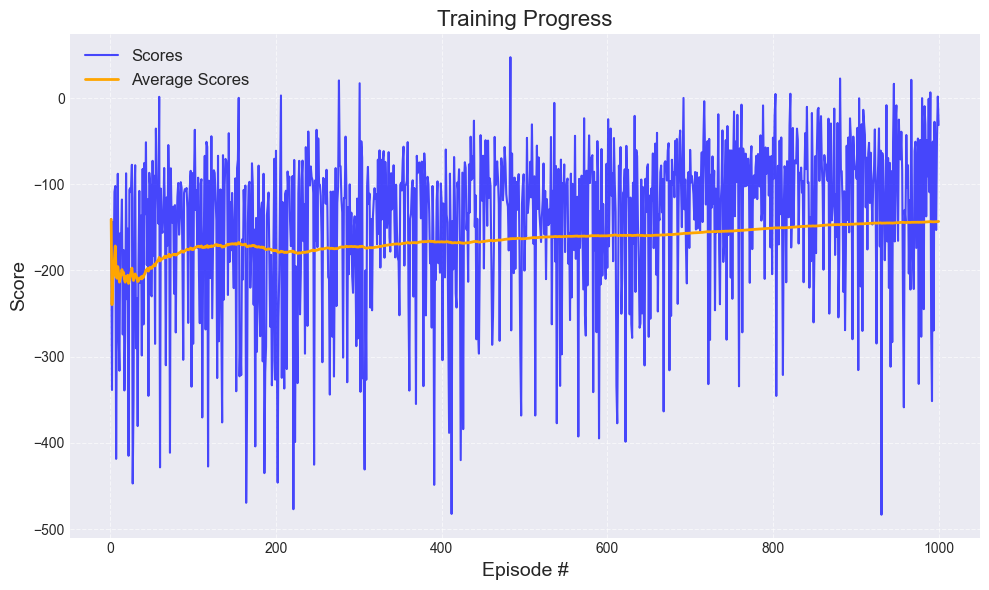

In [8]:
print(f"Length of scores: {len(scores)}. Length of avg_scores: {len(avg_scores)}")

plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(1, len(scores) + 1), scores, label="Scores", color="blue", alpha=0.7)
ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label="Average Scores", color="orange", linewidth=2)

ax.set_title("Training Progress", fontsize=16)
ax.set_xlabel("Episode #", fontsize=14)
ax.set_ylabel("Score", fontsize=14)

ax.legend(loc="best", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()